# Dreams of Whale
Try to implement deep dreams with the whale-recognizing neural network.

In [14]:
import tensorflow as tf
import numpy as np

import matplotlib as mpl

import IPython.display as display
from PIL import Image

from tensorflow.keras.preprocessing import image

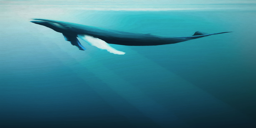

(128, 256, 3)


In [97]:
def getImg(location,max_size=None):
    img= Image.open(location)
    img = img.resize((256,128))
    if max_size is not None:
        img.thumbnail((max_size,max_size))
    return np.array(img)

def restore(img):
    img= 255*(img+1)/2
    return tf.cast(img,tf.uint8)

def show(img):
    display.display(PIL.Image.fromarray(np.array(img)))

mofo = getImg("clouds-mf.jpg")

show(mofo)
print(mofo.shape)

In [81]:
whaleboi = tf.keras.models.load_model("Model0.5_87perc.h5",custom_objects={"leaky_relu": tf.nn.leaky_relu})
whaleboi.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 256, 128)     9728      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 254, 64)      73792     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 127, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 125, 64)       36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 62, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 30, 64)        0

In [91]:
whaleboi = tf.keras.models.load_model("Model0.5_87perc.h5",custom_objects={"leaky_relu": tf.nn.leaky_relu})

# Layers to enhance :
layNam = ["dense_1","conv2d_2"]
layEn = [whaleboi.get_layer(nam).output for nam in layNam]

whaleDream = tf.keras.Model(inputs=whaleboi.input,outputs=layEn)

def calc_gain(img,model):
    # Pass the image forward to get activations.
    img_batch = tf.expand_dims(img,axis=0)
    layer_activations = model(img_batch)
    256
    if len(layer_activations)==1:
        layer_activations =[layer_activations]
    
    gains = []
    for act in layer_activations:
        gain = tf.math.reduce_mean(act)
        gains.append(gain)
    
    return tf.reduce_sum(gains)

In [83]:
class DeepDream(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
    )
    
    def __call__(self, img, steps, step_size):
        print("Tracing")
        gain = tf.constant(0.0)
        for n in tf.range(steps):
            with tf.GradientTape() as tape:
                # This needs gradients relative to `img`
                # `GradientTape` only watches `tf.Variable`s by default
                tape.watch(img)
                gain = calc_gain(img, self.model)

            # Calculate the gradient of the loss with respect to the pixels of the input image.
            gradients = tape.gradient(gain, img)

            # Normalize the gradients.
            gradients /= tf.math.reduce_std(gradients) + 1e-8 

            # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
            # You can update the image by directly adding the gradients (because they're the same shape!)
            img = img + gradients*step_size
            img = tf.clip_by_value(img, -1, 1)

        return gain, img

In [84]:
deepdre = DeepDream(whaleDream)

In [98]:
def run_dream_simple(img,steps=100,step_size=0.01):
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    print(img.shape)
    img = tf.convert_to_tensor(img)
    step_size = tf.convert_to_tensor(step_size)
    steps_remaining=steps
    step=0
    while steps_remaining:
        if(steps_remaining>100):
            run_steps=tf.constant(100)
        else:
            run_steps=tf.constant(steps_remaining)
        steps_remaining-=run_steps
        step+=run_steps
        
        gain,img = deepdre(img,run_steps,tf.constant(step_size))
        
        display.clear_output(wait=True)
        show(restore(img))
        print("Step {}, gain {}".format(step,gain))
        
    result = restore(img)
    display.clear_output(wait=True)
    show(result)

    return result

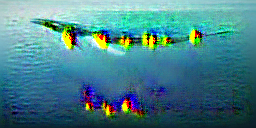

In [99]:
dream_img = run_dream_simple(img=mofo,steps=100,step_size=0.01)

In [100]:
gaga = Image.fromarray(dream_img.numpy())
gaga = gaga.resize((800,500))
gaga.show()